In [4]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import os

def plot_token_length_hist(dataset_path, tokenizer, min_length=0,
                           text_field="text", bins=100,
                           save_batch_size=None, save_dir=None):
    ds = load_from_disk(dataset_path)

    # Compute token lengths
    def _token_len(batch):
        enc = tokenizer(batch[text_field], add_special_tokens=False)
        return {"length": [len(ids) for ids in enc["input_ids"]]}

    ds = ds.map(
        _token_len,
        batched=True,
        num_proc=1,
        load_from_cache_file=False,
        keep_in_memory=True,
    )

    # Filter by minimum token length
    if min_length > 0:
        ds = ds.filter(lambda x: x["length"] >= min_length)

    lengths = ds["length"]
    print(f"number of documents ≥ {min_length} tokens: {len(lengths)}")

    # ---- SAVE FIRST BATCH ----
    if save_batch_size is not None and save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        subset = ds.select(range(min(save_batch_size, len(ds))))
        subset.save_to_disk(save_dir)
        print(f"Saved {len(subset)} documents to: {save_dir}")

    print(f"lengths: {lengths}")
    print(f"lengths: {lengths}")

    # ---- PLOT ----
    plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=bins)
    plt.xlabel("Document length (tokens)")
    plt.ylabel("Count")
    plt.title(f"C4 token-length histogram (min length = {min_length})")
    plt.tight_layout()
    plt.show()


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2557 > 1024). Running this sequence through the model will result in indexing errors


Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

number of documents ≥ 512 tokens: 78


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

Saved 64 documents to: ../data_long_ctx
lengths: [2557, 994, 1664, 669, 925, 1282, 554, 605, 1150, 644, 592, 5503, 547, 687, 1777, 1441, 915, 708, 865, 1810, 966, 1279, 1281, 621, 1121, 1335, 578, 513, 1171, 874, 616, 4202, 739, 972, 926, 897, 1277, 841, 1133, 896, 611, 1054, 1303, 1078, 552, 700, 3382, 580, 1266, 536, 880, 1446, 1458, 943, 2944, 631, 556, 798, 1302, 1034, 1512, 1388, 578, 3218, 734, 593, 1080, 1505, 790, 576, 1517, 525, 992, 1861, 781, 622, 554, 637]
lengths: [2557, 994, 1664, 669, 925, 1282, 554, 605, 1150, 644, 592, 5503, 547, 687, 1777, 1441, 915, 708, 865, 1810, 966, 1279, 1281, 621, 1121, 1335, 578, 513, 1171, 874, 616, 4202, 739, 972, 926, 897, 1277, 841, 1133, 896, 611, 1054, 1303, 1078, 552, 700, 3382, 580, 1266, 536, 880, 1446, 1458, 943, 2944, 631, 556, 798, 1302, 1034, 1512, 1388, 578, 3218, 734, 593, 1080, 1505, 790, 576, 1517, 525, 992, 1861, 781, 622, 554, 637]


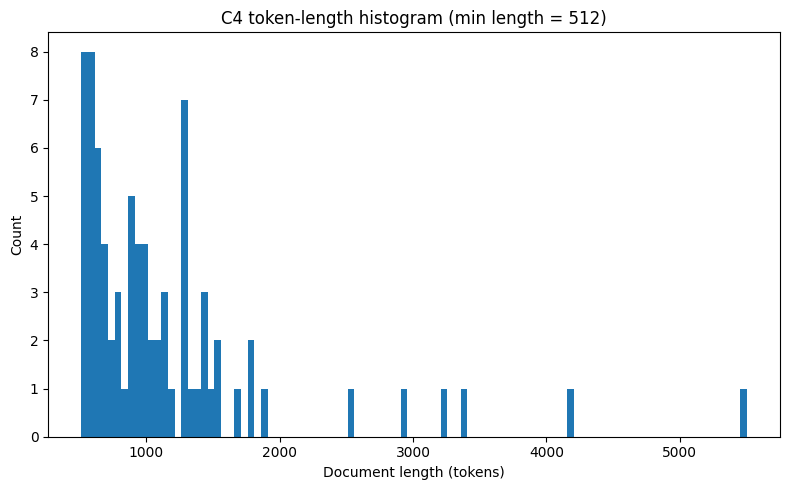

In [5]:
# Example usage:

from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("gpt2")
plot_token_length_hist("/home/janek/Documents/IDEAS/nano/data", tok, min_length=512, save_batch_size=64, save_dir='../data_long_ctx')

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

number of documents ≥ 0 tokens: 64


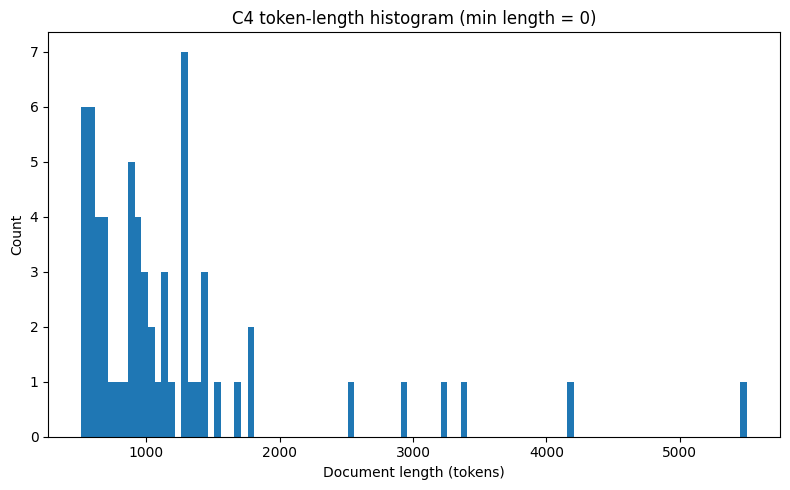

In [33]:
plot_token_length_hist("../data_long_ctx", tok)

../tmp/hist_normal.csv → total count: 364608
../tmp/hist_log.csv → total count: 364608


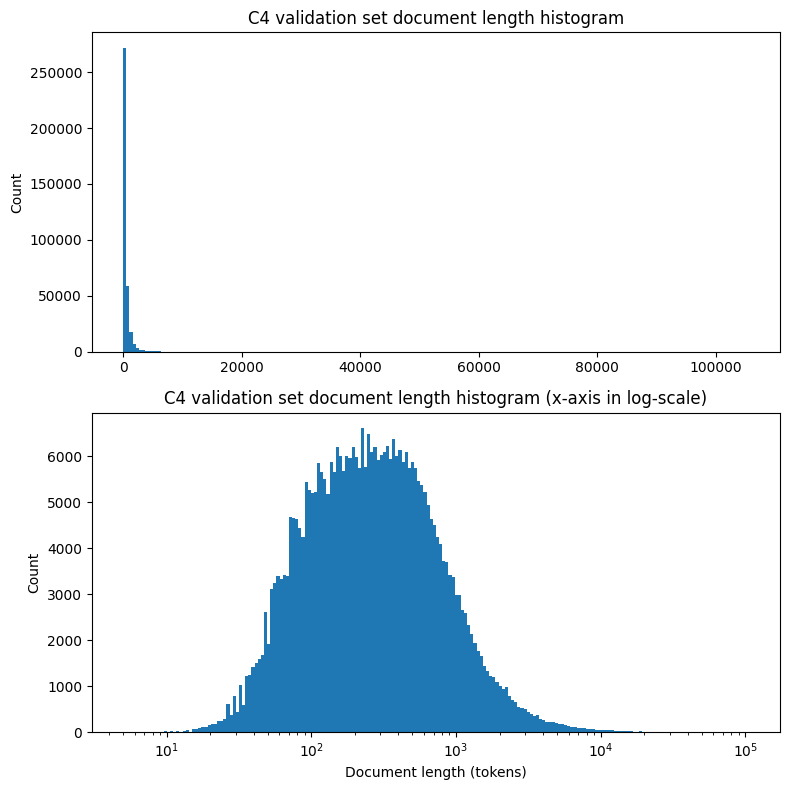

In [7]:
import csv
import matplotlib.pyplot as plt

def load_hist(csv_path):
    bin_left = []
    bin_right = []
    counts = []
    total = 0

    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            l = float(row["bin_left"])
            r = float(row["bin_right"])
            c = int(row["count"])
            bin_left.append(l)
            bin_right.append(r)
            counts.append(c)
            total += c

    widths = [r - l for l, r in zip(bin_left, bin_right)]
    centers = [(l + r) / 2 for l, r in zip(bin_left, bin_right)]
    print(f"{csv_path} → total count: {total}")
    return centers, counts, widths


def plot_histograms_one_figure(csv_and_scale_list):
    """
    csv_and_scale_list: [(csv_path, use_logscale)]
    Creates ONE figure with len(list) subplots.
    """
    n = len(csv_and_scale_list)
    fig, axs = plt.subplots(n, 1, figsize=(8, 4 * n), sharex=False)

    if n == 1:
        axs = [axs]  # edge case: 1 subplot

    for ax, (csv_path, use_log) in zip(axs, csv_and_scale_list):
        centers, counts, widths = load_hist(csv_path)

        ax.bar(centers, counts, width=widths, align="center")
        if use_log:
            ax.set_xscale("log")
            ax.set_title("C4 validation set document length histogram (x-axis in log-scale)")
        else:
            ax.set_title("C4 validation set document length histogram")

        ax.set_ylabel("Count")

    axs[-1].set_xlabel("Document length (tokens)")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    files = [
        ("../tmp/hist_normal.csv", False),
        ("../tmp/hist_log.csv", True),
    ]
    plot_histograms_one_figure(files)


In [8]:
import pandas as pd

df = pd.read_csv("../tmp/hist_log.csv")
df["suf_sum"] = df["count"][::-1].cumsum()[::-1]

df.to_csv('../tmp/suf_sum.csv', index=False)

In [ ]:
python src/context_scaling/long_context_batch_maker.py --dataset_path /storage_nvme_1/llm-random/datasets/c4/validation --tokenizer gpt2 --min_length 2048 --save_batch_size 8192 --save_data_dir /storage_nvme_1/llm-random/datasets/c4/long_context_2048n8192 --save_hist_dir tmp --num_workers 16 